# Yoga

<img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRAKXxG7yXe7pKloc8Gwf87aNc6UrLZi71MvQ&usqp=CAU" />

<br/>
<br/>

**Yoga** is a group of physical, mental, and spiritual practices or disciplines which originated in ancient India.

There is a broad variety of yoga schools, practices, and goals in Hinduism, Buddhism, and Jainism. The term "Yoga" in the Western world often denotes a modern form of hatha yoga and yoga as exercise, consisting largely of the postures or asanas.

The practice of yoga has been thought to date back to pre-vedic Indian traditions, possibly in the Indus valley civilization around 3000 BCE. Yoga is mentioned in the Rigveda, and also referenced in the Upanishads, though it most likely developed as a systematic study around the 5th and 6th centuries BCE, in ancient India's ascetic and Śramaṇa movements. The chronology of earliest texts describing yoga-practices is unclear, varyingly credited to the Upanishads. The Yoga Sutras of Patanjali date from the 2nd century BCE, and gained prominence in the west in the 20th century after being first introduced by Swami Vivekananda. Hatha yoga texts began to emerge sometime between the 9th and 11th century with origins in tantra.


**5 classes of yoga within datsset:**
    - Downdog
    - Goddess
    - Plank
    - Tree
    - Warrior2



## Downdog
<hr/>

<img src = 'https://yogadigest.com/wp-content/uploads/2014/09/madelyn-downdog.jpg' />

<br/>
<br/>

## Goddess
<hr>

<img src = 'https://833487.smushcdn.com/1695928/wp-content/uploads/2018/08/inner_goddess-01.jpg?lossy=1&strip=1&webp=1' />

<br/>
<br/>

## Plank
<hr>

<img src = 'https://www.theglobeandmail.com/resizer/e2P0Eu9t1YgOlW-T_cRMkdXELp8=/2048x0/filters:quality(80)/arc-anglerfish-tgam-prod-tgam.s3.amazonaws.com/public/TFNCQAP3PRCCDAPGBVTDQAACJE' />

<br/>
<br/>

## Tree
<hr>

<img src = 'https://images.vexels.com/media/users/3/153373/isolated/preview/71641356ed1e72233efb7513b357508c-tree-yoga-pose-silhouette-by-vexels.png' />

<br/>
<br/>

## Warrior
<hr>

<img src = 'https://purewows3.imgix.net/images/articles/2019_09/yoga-poses-for-kids-warrior-2.jpg?auto=format,compress&cs=strip' />

<br/>
<br/>

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input
from tensorflow.keras.applications import VGG19

from sklearn.metrics import classification_report, confusion_matrix

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#### Set base path

In [2]:
BASE_PATH = '../input/yoga-poses-dataset/DATASET/'

**Loading Data**

In [3]:
filenames,labels = [],[]

for dirname in os.listdir(f'{BASE_PATH}TRAIN'):
    for file in os.listdir(f'{BASE_PATH}TRAIN/{dirname}'):
        filenames.append(file)
        labels.append(dirname)

df_train = pd.DataFrame(data={
    'filename': filenames,
    'labels': labels
})

In [4]:
df_train.head()

,filename,labels
0,00000335.jpg,downdog
1,00000287.png,downdog
2,00000382.jpg,downdog
3,00000233.jpg,downdog
4,00000310.png,downdog


### There are 5 different classes

In [5]:
df_train.labels.value_counts()

plank       266
warrior2    252
downdog     223
goddess     180
tree        160
Name: labels, dtype: int64

### Displaying 5 images from each category

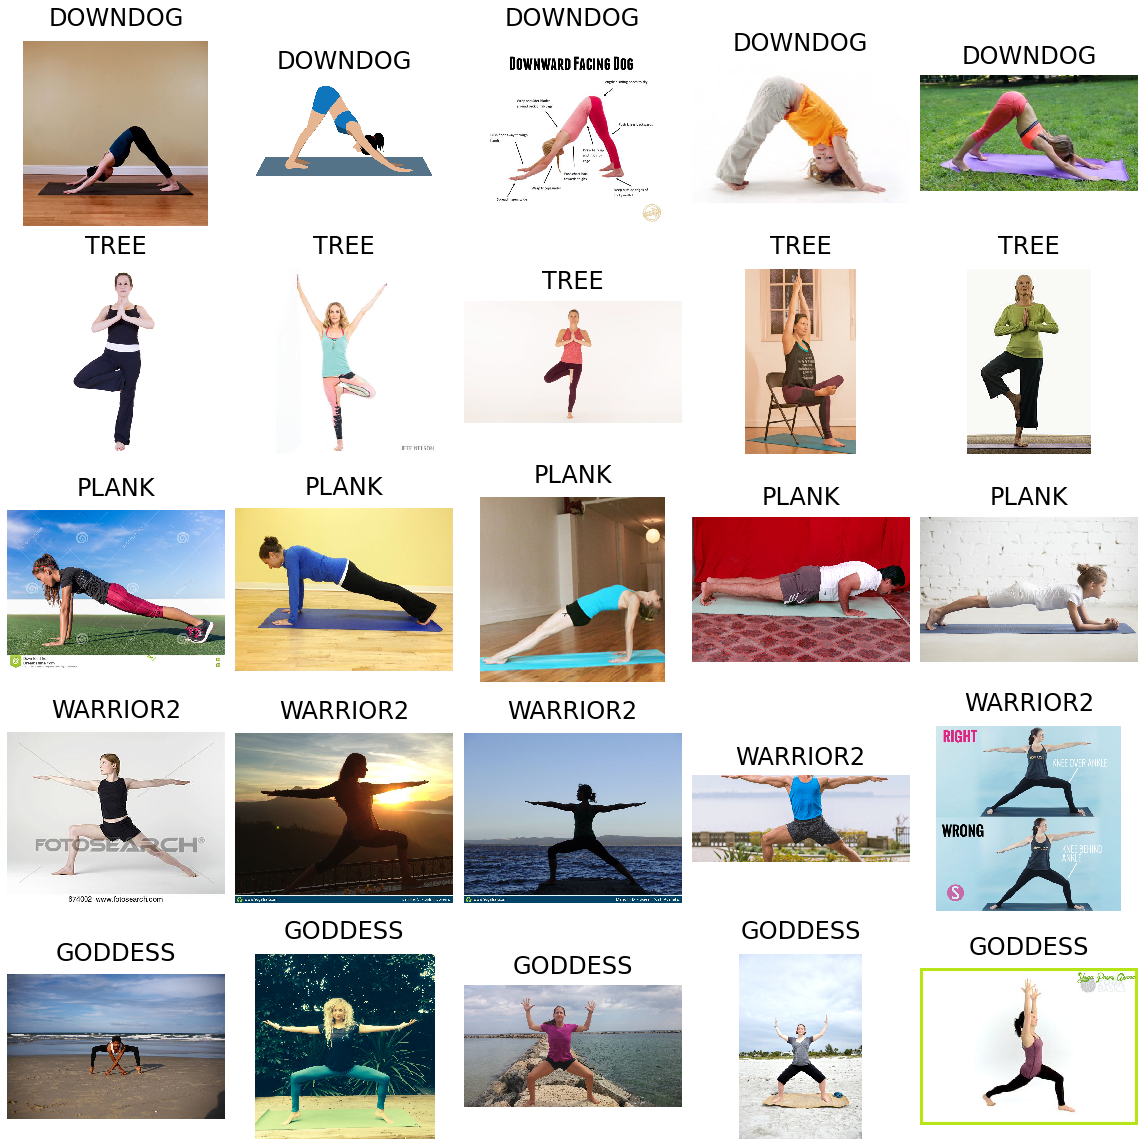

In [6]:
rows = 5
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(16, 16))
for i, row in enumerate(list(df_train.labels.unique())):
    for j, filename in enumerate(df_train[df_train.labels == row]['filename'].tolist()[:cols]):
        img = load_img(os.path.join(BASE_PATH,'TRAIN',row, filename))
        axs[i,j].matshow(img)
        axs[i,j].axis('off')
        axs[i,j].set_title(row.upper(), fontsize=24)
fig.tight_layout()

### Number of classes

In [7]:
num_classes = list(df_train.labels.unique())
print(num_classes)
len(num_classes)

['downdog', 'tree', 'plank', 'warrior2', 'goddess']


5

### Config params

In [8]:
IMG_H = 200
IMG_W = 200
IMG_C = 3

BATCH_SIZE = 32
EPOCHS = 30

### Data Augumentation using ImageDataGenerator

In [9]:
train_gen = ImageDataGenerator(rescale=1./255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               width_shift_range=0.12,
                               height_shift_range=0.12,
                               horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=1./255)

### Creating train, test set

In [10]:
train_set = train_gen.flow_from_directory(f'{BASE_PATH}TRAIN',
                                          target_size=(IMG_W,IMG_H),
                                          batch_size=BATCH_SIZE,
                                          class_mode='categorical')

test_set = test_gen.flow_from_directory(f'{BASE_PATH}TEST',
                                          target_size=(IMG_W,IMG_H),
                                          batch_size=BATCH_SIZE,
                                          class_mode='categorical')

Found 1081 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


### Create Model

In [11]:
def create_model():
    tf.keras.backend.clear_session()
    
    cmodel = VGG19(input_shape = (IMG_W, IMG_H, IMG_C), 
                         weights='imagenet', 
                         include_top=False,)
    
    # there is no need to train existing weights
    for layer in cmodel.layers:
        layer.trainable = False
        
    x = Flatten()(cmodel.output)
    #x = cmodel.output
 
    prediction = Dense(len(num_classes), activation='softmax')(x)

    # create model object
    model = Model(inputs = cmodel.input, outputs = prediction)
    
    return model

In [12]:
model = create_model()
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_______________________________________________________

In [13]:
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks_list = [es, lr_reduction]

history = model.fit(train_set,
                    validation_data=test_set,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    shuffle=True
                    )

Epoch 1/30
34/34 [==============================] - 61s 2s/step - loss: 1.2382 - accuracy: 0.5467 - val_loss: 0.3311 - val_accuracy: 0.8979
Epoch 2/30
34/34 [==============================] - 43s 1s/step - loss: 0.5282 - accuracy: 0.8233 - val_loss: 0.1733 - val_accuracy: 0.9596
Epoch 3/30
34/34 [==============================] - 41s 1s/step - loss: 0.3842 - accuracy: 0.8862 - val_loss: 0.1438 - val_accuracy: 0.9511
Epoch 4/30
34/34 [==============================] - 41s 1s/step - loss: 0.3797 - accuracy: 0.8816 - val_loss: 0.1251 - val_accuracy: 0.9638
Epoch 5/30
34/34 [==============================] - 40s 1s/step - loss: 0.2889 - accuracy: 0.9140 - val_loss: 0.1168 - val_accuracy: 0.9574
Epoch 6/30
34/34 [==============================] - 40s 1s/step - loss: 0.2534 - accuracy: 0.9306 - val_loss: 0.1138 - val_accuracy: 0.9574
Epoch 7/30
34/34 [==============================] - 41s 1s/step - loss: 0.2426 - accuracy: 0.9269 - val_loss: 0.1034 - val_accuracy: 0.9596
Epoch 8/30
34/34 [==

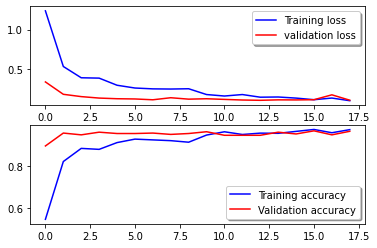

In [15]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Evaluate Model

In [16]:
model.evaluate(train_set), model.evaluate(test_set)

15/15 [==============================] - 13s 854ms/step - loss: 0.0980 - accuracy: 0.9681


([0.10665305703878403, 0.9666975140571594],
 [0.09802501648664474, 0.9680851101875305])

### Extract label from test_set

In [17]:
y_val_org = []
for i in range( test_set.__len__() ):
    y_val_org.extend(
        test_set.__getitem__( i )[1] 
    )
y_val_org = np.array(y_val_org)
y_val_org = np.argmax(y_val_org, axis=1)

In [18]:
y_val_org

array([2, 2, 4, 4, 4, 0, 0, 0, 0, 1, 2, 2, 3, 2, 2, 4, 4, 0, 2, 2, 4, 3,
       2, 2, 2, 2, 1, 3, 4, 2, 4, 0, 1, 4, 1, 2, 2, 2, 4, 1, 4, 0, 3, 4,
       1, 4, 0, 4, 4, 4, 1, 3, 1, 3, 3, 4, 4, 4, 0, 1, 0, 4, 4, 3, 1, 2,
       3, 2, 0, 1, 3, 1, 4, 2, 4, 3, 2, 4, 1, 4, 4, 2, 4, 3, 4, 2, 0, 2,
       4, 2, 0, 0, 0, 3, 3, 4, 4, 0, 4, 4, 4, 1, 2, 0, 2, 4, 0, 4, 1, 4,
       0, 3, 2, 3, 1, 4, 3, 2, 4, 4, 2, 4, 1, 3, 0, 0, 0, 2, 0, 0, 3, 4,
       2, 0, 1, 2, 1, 3, 3, 1, 4, 2, 1, 4, 2, 4, 0, 0, 2, 2, 0, 0, 2, 0,
       2, 2, 4, 1, 2, 1, 2, 1, 4, 3, 4, 1, 3, 2, 4, 1, 4, 1, 3, 4, 4, 2,
       2, 4, 4, 2, 1, 0, 4, 3, 4, 0, 4, 2, 0, 0, 1, 2, 2, 0, 1, 4, 0, 3,
       2, 3, 4, 3, 0, 4, 1, 4, 1, 3, 3, 1, 4, 2, 2, 4, 3, 3, 2, 3, 4, 3,
       0, 2, 4, 3, 4, 1, 1, 1, 1, 2, 0, 1, 1, 2, 4, 0, 4, 0, 3, 0, 0, 0,
       2, 3, 4, 3, 4, 4, 3, 3, 0, 3, 1, 3, 3, 4, 0, 4, 1, 4, 3, 0, 2, 2,
       3, 2, 0, 1, 3, 2, 4, 0, 4, 1, 4, 0, 0, 1, 1, 0, 1, 4, 4, 4, 2, 0,
       0, 2, 4, 2, 3, 3, 4, 3, 2, 2, 0, 0, 4, 2, 1,

### Predict Test data

In [19]:
ypreds = model.predict(test_set)
ypreds = np.argmax(ypreds, axis=1)
ypreds

array([2, 2, 4, 4, 4, 0, 0, 0, 0, 1, 2, 2, 3, 2, 2, 4, 4, 0, 2, 2, 4, 3,
       2, 2, 2, 2, 1, 3, 4, 2, 4, 0, 1, 4, 1, 2, 2, 2, 4, 1, 1, 0, 3, 4,
       1, 4, 0, 4, 4, 4, 1, 3, 1, 3, 3, 4, 1, 4, 0, 1, 0, 4, 4, 3, 1, 2,
       3, 2, 0, 1, 3, 1, 4, 2, 4, 3, 2, 4, 2, 4, 4, 2, 4, 3, 4, 2, 0, 2,
       4, 2, 0, 0, 0, 3, 3, 4, 4, 0, 4, 4, 4, 1, 2, 0, 2, 4, 0, 4, 1, 4,
       0, 3, 2, 3, 1, 4, 3, 2, 0, 4, 2, 4, 1, 3, 0, 0, 0, 2, 0, 0, 3, 4,
       2, 0, 1, 2, 1, 3, 3, 1, 4, 2, 1, 4, 2, 4, 0, 0, 2, 2, 0, 0, 2, 0,
       2, 2, 4, 1, 2, 2, 2, 1, 4, 3, 4, 1, 3, 2, 0, 1, 4, 1, 3, 4, 4, 2,
       2, 4, 1, 2, 1, 0, 4, 3, 4, 0, 4, 2, 0, 0, 1, 2, 2, 0, 1, 4, 0, 3,
       2, 3, 4, 3, 0, 0, 1, 4, 1, 3, 3, 1, 4, 2, 2, 4, 3, 3, 2, 3, 4, 3,
       0, 2, 4, 3, 4, 1, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 4, 0, 3, 0, 0, 0,
       2, 3, 4, 3, 4, 4, 3, 3, 0, 3, 1, 3, 3, 4, 0, 4, 1, 4, 3, 0, 2, 2,
       3, 2, 0, 1, 3, 2, 1, 0, 4, 1, 4, 0, 0, 1, 1, 0, 1, 4, 0, 4, 2, 0,
       0, 2, 4, 2, 3, 3, 4, 3, 2, 2, 0, 0, 4, 2, 1,

### Confusion matrix and Classification Report

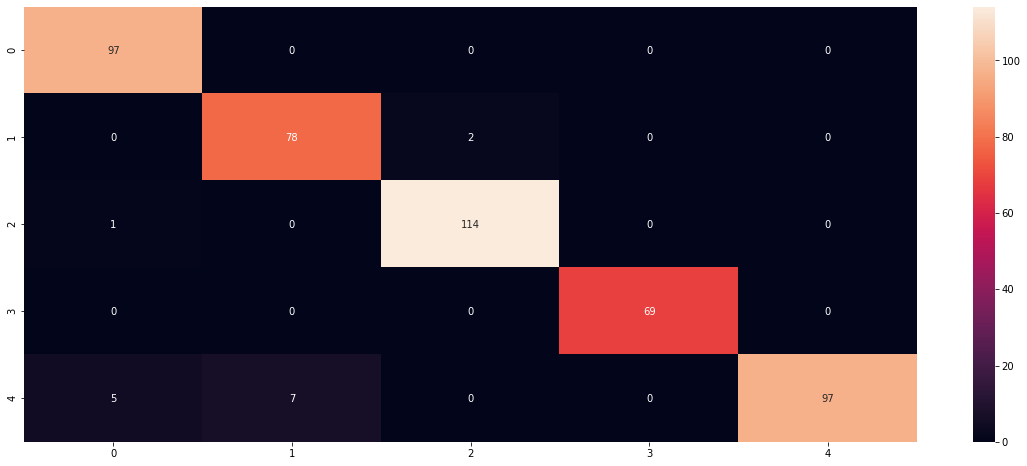




              precision    recall  f1-score   support

           0       0.94      1.00      0.97        97
           1       0.92      0.97      0.95        80
           2       0.98      0.99      0.99       115
           3       1.00      1.00      1.00        69
           4       1.00      0.89      0.94       109

    accuracy                           0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470



In [20]:
cf_matrix = confusion_matrix(y_val_org, ypreds)

plt.figure(figsize=(20,8))
ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.show()

print("\n\n")
print(classification_report(y_val_org, ypreds))